**Problem Statement**


You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

Credit card / Prepaid card

Bank account services

Theft/Dispute reporting

Mortgages/loans

Others

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

---



Need to perform the following eight major tasks to complete the assignment:

Data loading

Text preprocessing

Exploratory data analysis (EDA)

Feature extraction

Topic modelling

Model building using supervised learning

Model training and evaluation

Model inference

In [2]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 12.3 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=7501d263f74a251a7d8a179b060dfb42801d19cf7d4b7c18a4c2b33def83e99f
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [3]:
# Importing libraries
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

**Loading the data**

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
f = open('/content/gdrive/My Drive/Automatic_Ticket_Classification/complaints.json')

In [9]:
data = json.load(f)
df=pd.json_normalize(data)

In [10]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#shape of dataframe
df.shape

(78313, 22)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [13]:

df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [14]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [15]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [16]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [17]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [18]:
#New shape of df
df.shape

(21072, 22)

**Prepare the text for topic modeling**

Once you have removed all the blank complaints, you need to:

Make the text lowercase
Remove text in square brackets
Remove punctuation
Remove words containing numbers
Once you have done these cleaning operations you need to perform the following:

Lemmatize the texts
Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [19]:
# Function to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [20]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaint_what_happened'].apply(clean_data)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agen...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a ticket i came across...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [21]:
#Write function to Lemmatize the texts
def lemma_texts(text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [22]:
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaints']), axis=1)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaints','lemmatized_complaint']]

In [24]:
df_clean.head()

,complaints,lemmatized_complaint
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


In [25]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str



df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaint,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...


In [27]:
df_clean1 = df_clean

**EDA**

Visualise the data according to the 'Complaint' character length

Using a word cloud find the top 40 words by frequency among all the articles after processing the text

Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

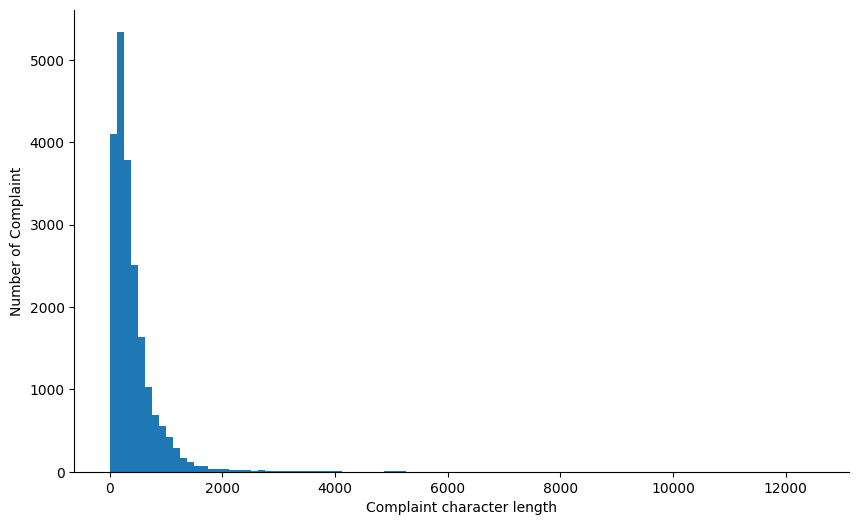

In [28]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

top 40 words by frequency among all the articles after processing the text.

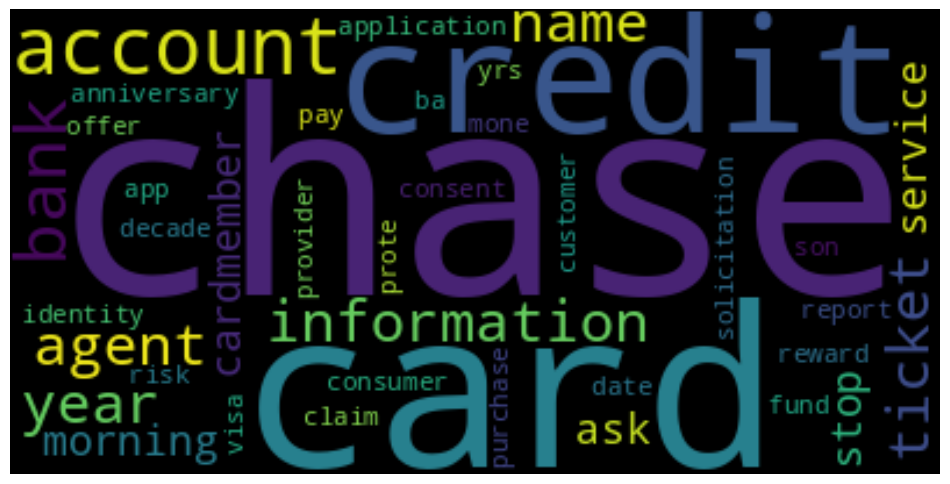

In [29]:
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head()

,complaints,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,54877
1,account,47678
2,credit,33682
3,card,30420
4,bank,21980
5,payment,21362
6,time,16304
7,charge,14433
8,day,13323
9,check,12389


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [33]:
#top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [34]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12928
1,credit report,3977
2,account chase,3210
3,customer service,3082
4,chase credit,2939
5,chase account,2793
6,account account,2569
7,bank account,2505
8,check account,2381
9,chase bank,2197


In [35]:
#the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [36]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,1944
1,credit card account,1115
2,credit card company,997
3,credit card chase,770
4,credit card credit,529
5,inquiry credit report,523
6,account credit card,454
7,charge credit card,417
8,card credit card,412
9,chase customer service,405


Removing personal details of customer has been masked in the dataset with xxxx.

In [37]:

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


**Feature Extraction**

Convert the raw texts to a matrix of TF-IDF features


**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0

In [40]:
dtm = tfidf.fit_transform(df_clean['complaints'])

**Topic Modelling using NMF**

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

Find the best number of clusters
Apply the best number to create word clusters
Inspect & validate the correction of each cluster wrt the complaints
Correct the labels if needed
Map the clusters to topics/cluster names

In [41]:
from sklearn.decomposition import NMF

**Manual Topic Modeling**

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [43]:

nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

14985

In [44]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [45]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4])

In [46]:

#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [47]:
df_clean.head()

,complaints,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,2
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,1
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3


In [48]:
#Print the first 5 Complaint for each of the Topics
First5_comp=df_clean.groupby('Topic').head(5)
First5_comp.sort_values('Topic')

,complaints,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
21,on i made a payment to an online retailer usin...,on I make a payment to an online retailer use ...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,0
43,chase sent me an email today with the innocuou...,chase send I an email today with the innocuous...,chase email today title information regard cha...,chase email today title information regard cha...,0
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and be neve...,sofa love seat table chair debit card charge b...,sofa love seat table chair debit card charge b...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,1
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,1
26,i have reached out to several times in attempt...,I have reach out to several time in attempt to...,time attempt inquiry remove creditor inquiry r...,time attempt inquiry remove creditor inquiry r...,1


Evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:

Bank Account services

Credit card or prepaid card

Theft/Dispute Reporting

Mortgage/Loan

Others

In [50]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

Supervised model to predict any new complaints to the relevant Topics.
You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean

,complaints,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,2
2,i upgraded my card in and was told by the agen...,I upgrade my card in and be tell by the agent ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,1
11,on while trying to book a ticket i came across...,on while try to book a ticket I come across an...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,0
78311,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,4


In [53]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [54]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit for yrs i ve had ch...,4


In [55]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

To perform atleast 3 models on the train & test data from these options:

Logistic regression

Decision Tree

Random Forest

Naive Bayes (optional)

In [56]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [57]:
#train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.3, random_state=42)

1. Logistic Regression

In [58]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1411
           1       0.96      0.95      0.96      1318
           2       0.97      0.95      0.96      1103
           3       0.94      0.97      0.96      1695
           4       0.96      0.89      0.93       795

    accuracy                           0.95      6322
   macro avg       0.95      0.94      0.95      6322
weighted avg       0.95      0.95      0.95      6322



2. Decision Tree

In [59]:

# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1411
           1       0.80      0.80      0.80      1318
           2       0.80      0.82      0.81      1103
           3       0.79      0.80      0.80      1695
           4       0.72      0.68      0.70       795

    accuracy                           0.77      6322
   macro avg       0.77      0.76      0.76      6322
weighted avg       0.77      0.77      0.77      6322



3. Random Forest Classifier

In [60]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1411
           1       0.74      0.82      0.78      1318
           2       0.89      0.77      0.83      1103
           3       0.59      0.97      0.73      1695
           4       0.98      0.08      0.15       795

    accuracy                           0.72      6322
   macro avg       0.81      0.66      0.64      6322
weighted avg       0.78      0.72      0.68      6322



4. Naive Bayes

In [61]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.49      0.36      0.41      1411
           1       0.35      0.28      0.31      1318
           2       0.51      0.50      0.50      1103
           3       0.46      0.31      0.37      1695
           4       0.19      0.47      0.27       795

    accuracy                           0.37      6322
   macro avg       0.40      0.38      0.37      6322
weighted avg       0.42      0.37      0.38      6322



**Logistic Regression is performing better**

Inferencing the best model


In [63]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [64]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [65]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Credit card or prepaid card
3,"Yesterday, I received a fraudulent email regar...",Account Services
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and...,Credit card or prepaid card


**Conclusion**

Results of 5 topics were indetified:

Account Services

Others

Mortgage/Loan

Credit card or prepaid card

Theft/Dispute Reporting

4 models representation on the data with accuracies as follows:

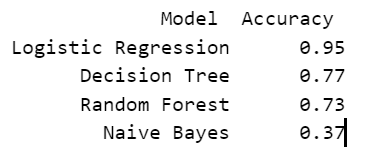

**Logistic Regression** has highest accuracy of ***0.95***, it is a good fit for this particular case study.